In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import gensim
import nltk
nltk.download('punkt')

import seaborn as sns
import matplotlib.pyplot as plt

import ast

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#!pip install tensorflow

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Bidirectional, LSTM

from joblib import load

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# I will be creating two ensemble models. One combining the best Logistic Regression model for lyric content, Using TFIDF Vectorizer, with the best song-level lyric sentiment model, Decision Tree Classifier. The other combines the best Logistic Regression model for lyric content, Using TFIDF Vectorizer, with the best line-level lyric sentiment model, Recurrent Neural Network. I will test the Naive Bayes classifier as well.

## A. Base steps applicable to both ensemble models

### 1. Import the data/word2vec/models and set up

#### a. Import the custom word2vec model that I created

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/word_two_vec_model.model"
model_w2v = Word2Vec.load(model_path)

#### b. Processing lines into tokens

In [ ]:
ensemble_lr = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/train_clean_w_sentiment.csv')

In [ ]:
lyric_lists = [song.splitlines() for song in ensemble_lr['Lyrics']]
ensemble_lr['Lyrics as Lists'] = lyric_lists
ensemble_lr.head(2)

,Unnamed: 0.1,Unnamed: 0,Artist,Song,Genre,Language,Lyrics,Sentiment,Lyrics as Lists
0,0,78168,franz ferdinand,swallow smile,Rock,en,I rise and curse the waking day\nCurse the gri...,0,"[I rise and curse the waking day, Curse the gr..."
1,1,155890,ry cooder,big bad bill is sweet william now,Rock,en,In the town of Louisville they got a man they ...,-1,[In the town of Louisville they got a man they...


In [ ]:
train_lr, val_lr = train_test_split(ensemble_lr, test_size=0.2, random_state=24, stratify = ensemble_lr['Genre'])

#### c. Prep data for logistic regression and import the trained logistic regression for lyric content

The trained model comes from the baselineLogisticRegressionModel notebook, in which all of the steps are outlined.

In [ ]:
train_lyrics = train_lr['Lyrics as Lists']
val_lyrics = val_lr['Lyrics as Lists']

In [ ]:
def lyrics_to_embeddings(lines, model):
     tokenized_lines = [word_tokenize(line.lower()) for line in lines]
     embeddings = [model.wv[word] for line in tokenized_lines for word in line if word in model.wv.key_to_index]
     return embeddings

In [ ]:
train_lr['Embeddings'] = train_lr['Lyrics as Lists'].apply(lambda x: lyrics_to_embeddings(x, model_w2v))
val_lr['Embeddings'] = val_lr['Lyrics as Lists'].apply(lambda x: lyrics_to_embeddings(x, model_w2v))

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_lr['Lyrics'])
tfidf_matrix_val = tfidf_vectorizer.transform(val_lr['Lyrics'])

In [ ]:
X_train = np.column_stack([tfidf_matrix_train.toarray(), np.vstack(train_lr['Embeddings'].apply(lambda x: np.mean(x, axis=0)))])
X_val = np.column_stack([tfidf_matrix_val.toarray(), np.vstack(val_lr['Embeddings'].apply(lambda x: np.mean(x, axis=0)))])
y_train = train_lr['Genre']
y_val = val_lr['Genre']

In [ ]:
scaler_lr = StandardScaler()
LR_train_scaled = scaler_lr.fit_transform(X_train)
LR_val_scaled = scaler_lr.transform(X_val)

In [ ]:
model_log_reg_tfidf = load('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/best_log_reg_content.joblib')

## B. Song-Level Lyric sentiment Ensemble Model

### 1. Train the Decision Tree for sentiment

In [ ]:
X_train_dtc = train_lr['Sentiment']
y_train = train_lr['Genre']

X_val_dtc = val_lr['Sentiment']
y_val = val_lr['Genre']

In [ ]:
scaler_dtc = StandardScaler()
X_train_dtc = scaler_dtc.fit_transform(np.array(X_train_dtc).reshape(-1,1))
X_val_dtc = scaler_dtc.transform(np.array(X_val_dtc).reshape(-1,1))

In [ ]:
model_dtc_sent = DecisionTreeClassifier()
model_dtc_sent.fit(np.array(X_train_dtc).reshape(-1,1), np.array(y_train).reshape(-1,1))

DecisionTreeClassifier()

### 2. Create and run the blended model

In [ ]:
class LogRegVotingClassifierDTC:
    def __init__(self, models, lr_weight=10, dtc_weight=10):
        self.models = models
        self.lr_weight = lr_weight
        self.dtc_weight = dtc_weight

    # def fit(self, X_lr, X_dtc, y):
    #     for model_type, model in self.models.items():
    #         if model_type == "log_reg":
    #             model.fit(X_lr, y)
    #         elif model_type == "dtc":
    #             model.fit(X_dtc, y)
    #         else:
    #             raise ValueError(f"Unknown model type: {model_type}")
    #     return self

    def predict(self, X_lr, X_dtc):
        lr_probabilities = self.models["log_reg"].predict_proba(X_lr)
        dtc_probabilities = self.models["dtc"].predict_proba(X_dtc)

        # Weighted average of class probabilities from both models
        weighted_avg_probabilities = (
            self.lr_weight * lr_probabilities + self.dtc_weight * dtc_probabilities
        ) / (self.lr_weight + self.dtc_weight)

        # Get the class with the maximum weighted average probability
        predicted_classes = np.argmax(weighted_avg_probabilities, axis=1)

        return predicted_classes

In [ ]:
ensemble_classifier_lr = LogRegVotingClassifierDTC(models={"log_reg": model_log_reg_tfidf, "dtc": model_dtc_sent})

#ensemble_classifier_lr.fit(LR_train_scaled, X_train_dtc, y_train)

# Standardize test features
X_val_lr_scale = scaler_lr.transform(LR_val_scaled)
X_val_dtc_scale = scaler_dtc.transform(X_val_dtc)

# Make predictions using the ensemble classifier
y_pred = ensemble_classifier_lr.predict(X_val_lr_scale, X_val_dtc_scale)

In [ ]:
y_pred

array([7, 0, 9, ..., 3, 3, 6])

In [ ]:
class_index_to_name = {0: 'Country', 1: 'Electronic', 2: 'Folk', 3: 'Hip-Hop', 4: 'Indie', 5: 'Jazz', 6: 'Metal', 7: 'Pop', 8: 'R&B', 9: 'Rock'}

# Convert predicted indices back to class names
y_pred_class_names = [class_index_to_name[idx] for idx in y_pred]

### 3. Evaluate the model

In [ ]:
# Evaluate accuracy
accuracy = accuracy_score(y_val, y_pred_class_names)
print(accuracy)

0.25466666666666665


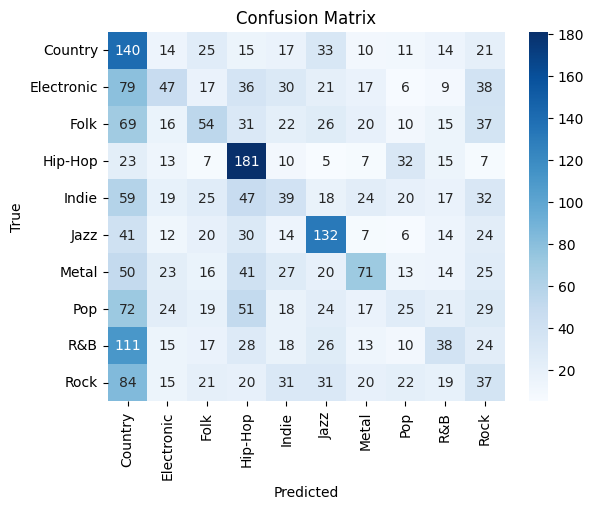

In [ ]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']

cm = confusion_matrix(y_val, y_pred_class_names, labels = genre_names)

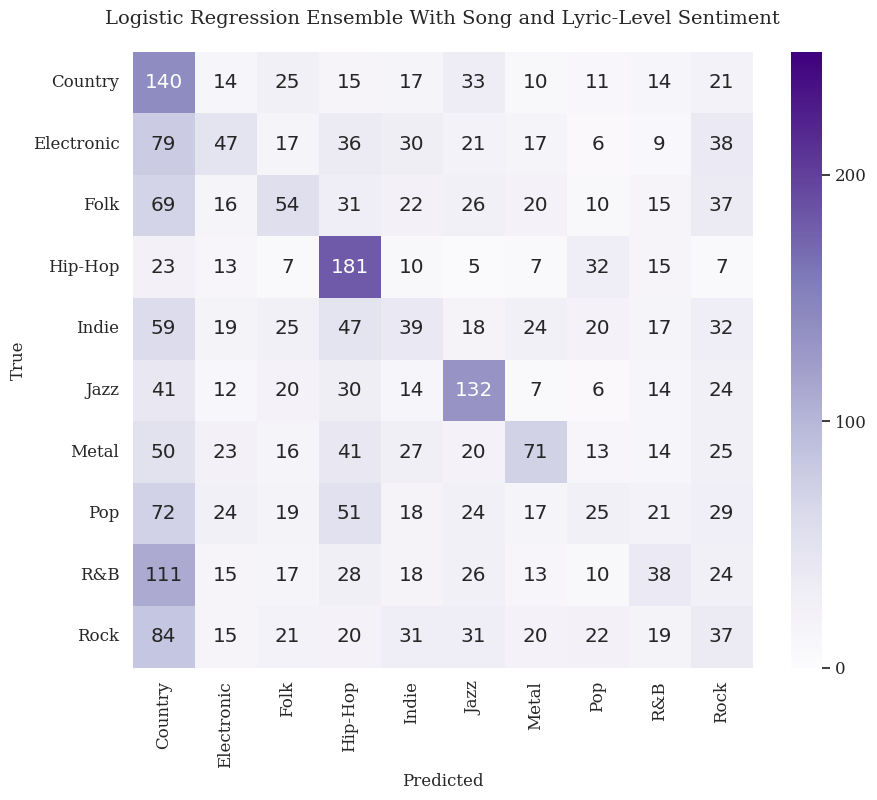

In [ ]:
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(cm, annot=True,fmt='d',cmap='Purples',xticklabels=genre_names,yticklabels=genre_names,vmin=0,
    vmax=250,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)
heatmap.set_yticklabels(
    heatmap.get_yticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)

cbar = heatmap.collections[0].colorbar
cbar.ax.yaxis.set_major_locator(MultipleLocator(100))

for label in cbar.ax.yaxis.get_ticklabels():
    label.set_fontname('Serif')
    label.set_fontsize(12)

plt.xlabel('Predicted', fontsize=12, fontfamily='Serif')
plt.ylabel('True', fontsize=12, fontfamily='Serif')
plt.title('Logistic Regression Ensemble With Song and Lyric-Level Sentiment', fontsize=14, fontfamily='Serif', pad = 20)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/log_reg_song_level_dtc.png', bbox_inches='tight')

## C. Line-Level Lyric Semantic Ensemble Models

### 1. Import and pre-process the sentiment data
These steps are outlined more in the lyric sentiment notebook

In [ ]:
sent_data_subset_line = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/train_sentiment_lines_sciclone_complete.csv')

In [ ]:
train_lr_sent_line, val_lr_sent_line = train_test_split(sent_data_subset_line, test_size=0.2, random_state=24, stratify = sent_data_subset_line['Genre'])

In [ ]:
X_train_line = np.array(train_lr_sent_line['SentimentLines'])
y_train_line = train_lr_sent_line['Genre']

X_val_line = np.array(val_lr_sent_line['SentimentLines'])
y_val_line = val_lr_sent_line['Genre']

In [ ]:
X_train_line = np.array([ast.literal_eval(s) for s in X_train_line])
X_val_line = np.array([ast.literal_eval(s) for s in X_val_line])

In [ ]:
label_encoder = LabelEncoder()
y_train_line_encoded = label_encoder.fit_transform(y_train_line)
y_train_one_hot = to_categorical(y_train_line_encoded, num_classes=10)

In [ ]:
X_train_line = np.array(X_train_line)
y_train_one_hot = np.array(y_train_one_hot)

In [ ]:
max_sequence_length = 41
X_train_padded = pad_sequences(X_train_line, maxlen=max_sequence_length, padding='post', truncating='post')

In [ ]:
X_train_padded_shifted = X_train_padded + 5

Validation data:

In [ ]:
y_val_line_encoded = label_encoder.fit_transform(y_val_line)
y_val_one_hot = to_categorical(y_val_line_encoded, num_classes=10)

In [ ]:
X_val_line = np.array(X_val_line)
y_val_one_hot = np.array(y_val_one_hot)

In [ ]:
X_val_padded = pad_sequences(X_val_line, maxlen=41, padding='post', truncating='post')
X_val_padded_shifted = X_val_padded + 5

In [ ]:
y_train_labels = np.argmax(y_train_one_hot, axis=1)

### 2. Train the Naive Bayes Classifier for Sentiment

In [ ]:
scaler_nb = StandardScaler()
X_train_nb = scaler_nb.fit_transform(X_train_padded_shifted)
X_val_nb= scaler_nb.transform(X_val_padded_shifted)

In [ ]:
model_nb_sent = GaussianNB()
model_nb_sent.fit(X_train_nb, np.array(y_train_labels))

GaussianNB()

### 3. Create and run the blended model

In [ ]:
class LogRegVotingClassifierNB:
    def __init__(self, models, lr_weight = 1, nb_weight = 1):
        self.models = models
        self.lr_weight = lr_weight
        self.nb_weight = nb_weight

    def fit(self, X_lr, X_nb, y):
        for model_type, model in self.models.items():
            if model_type == "log_reg":
                model.fit(X_lr, y)
            elif model_type == "nb":
                model.fit(X_nb, y)
            else:
                raise ValueError(f"Unknown model type: {model_type}")
        return self

    def predict(self, X_lr, X_nb):
        lr_probabilities = self.models["log_reg"].predict_proba(X_lr)
        nb_probabilities = self.models["nb"].predict_proba(X_nb)

        # Weighted average of class probabilities from both models
        weighted_avg_probabilities = (
            self.lr_weight * lr_probabilities + self.nb_weight * nb_probabilities
        ) / (self.lr_weight + self.nb_weight)

        # Get the class with the maximum weighted average probability
        predicted_classes = np.argmax(weighted_avg_probabilities, axis=1)

        return predicted_classes

In [ ]:
ensemble_classifier_lr_nb = LogRegVotingClassifierNB(models={"log_reg": model_log_reg_tfidf, "nb": model_nb_sent})

ensemble_classifier_lr_nb.fit(LR_train_scaled, X_train_nb, y_train_labels)

# Standardize test features
X_val_lr_scale = scaler_lr.transform(LR_val_scaled)
X_val_nb_scale = scaler_nb.transform(X_val_nb)

# Make predictions using the ensemble classifier
y_pred = ensemble_classifier_lr_nb.predict(X_val_lr_scale, X_val_nb_scale)

### 4. Evaluate the model

In [ ]:
class_index_to_name = {0: 'Country', 1: 'Electronic', 2: 'Folk', 3: 'Hip-Hop', 4: 'Indie', 5: 'Jazz', 6: 'Metal', 7: 'Pop', 8: 'R&B', 9: 'Rock'}

# Convert predicted indices back to class names
y_pred_class_names = [class_index_to_name[idx] for idx in y_pred]

In [ ]:
# Evaluate accuracy
accuracy = accuracy_score(y_val, y_pred_class_names)
print(accuracy)

0.25466666666666665


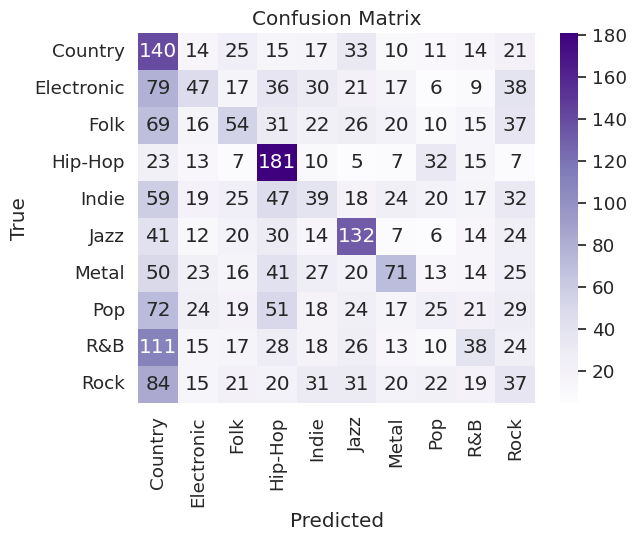

In [ ]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']

cm = confusion_matrix(y_val, y_pred_class_names, labels = genre_names)

sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels= genre_names, yticklabels=genre_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 5. Train the Recurrent Neural Network for Sentiment

In [ ]:
scaler_rnn = StandardScaler()
X_train_rnn = scaler_rnn.fit_transform(X_train_padded_shifted)
X_val_rnn = scaler_rnn.transform(X_val_padded_shifted)

Importing the optimized RNN, more steps can be found in the Lyric Sentiment Notebook.

In [ ]:
model_rnn = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/model_sentiment_line_rnn")

### 6. Create and run the blended model

In [ ]:
class LogRegVotingClassifierRNN:
    def __init__(self, models, lr_weight=1, rnn_weight=1):
        self.models = models
        self.lr_weight = lr_weight
        self.rnn_weight = rnn_weight

    # def fit(self, X_lr, X_rnn, y):
    #     for model_type, model in self.models.items():
    #         if model_type == "log_reg":
    #             model.fit(X_lr, np.argmax(y, axis=1))
    #         elif model_type == "rnn":
    #             model.fit(X_rnn, y, epochs=5, batch_size=32, validation_split=0.2)
    #         else:
    #             raise ValueError(f"Unknown model type: {model_type}")
    #     return self

    def predict(self, X_lr, X_rnn):
        lr_probabilities = self.models["log_reg"].predict_proba(X_lr)
        rnn_probabilities = self.models["rnn"].predict(X_rnn)

        # Ensure lr_probabilities is a 2D array
        if lr_probabilities.ndim == 1:
            lr_probabilities = np.column_stack([1 - lr_probabilities, lr_probabilities])

        # Weighted average of class probabilities from both models
        weighted_avg_probabilities = (
            self.lr_weight * lr_probabilities + self.rnn_weight * rnn_probabilities
        ) / (self.lr_weight + self.rnn_weight)

        # Get the class with the maximum weighted average probability
        predicted_classes = np.argmax(weighted_avg_probabilities, axis=1)

        return predicted_classes

In [ ]:
ensemble_classifier_lr_rnn = LogRegVotingClassifierRNN(models={"log_reg": model_log_reg_tfidf, "rnn": model_rnn})
#ensemble_classifier_lr_rnn.fit(LR_train_scaled, X_train_rnn, y_train_one_hot)

X_val_lr_scale = scaler_lr.transform(LR_val_scaled)
X_val_rnn_scale = scaler_rnn.transform(X_val_rnn)

In [ ]:
y_pred = ensemble_classifier_lr_rnn.predict(X_val_lr_scale, X_val_rnn_scale)

94/94 [==============================] - 0s 4ms/step


### 7. Evaluate the model

In [ ]:
y_val_labels = np.argmax(y_val_one_hot, axis=1)

In [ ]:
true_labels = y_val_labels

ensemble_predictions = ensemble_classifier_lr_rnn.predict(X_val_lr_scale, X_val_rnn_scale)
ensemble_predictions

94/94 [==============================] - 0s 4ms/step


array([7, 0, 9, ..., 3, 3, 6])

In [ ]:
true_labels

array([3, 0, 7, ..., 6, 3, 0])

In [ ]:
accuracy = accuracy_score(true_labels, ensemble_predictions)
accuracy

0.25466666666666665